In [1]:
import pandas as pd
import numpy as np


import os
os.chdir('../')


from run_utils import read_data

data, data_test, categories = read_data(
    './data/All_browse_data_без_погружения_19971021_20230107_с_пропусками.csv')

data.head()

/Users/gadzhiev-im/miniconda3/envs/tf_kp/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


,year,month,day,hour from,hour to,doySin,hourSin,doyCos,hourCos,Dst,...,lg(E>2 MeV),E>2 MeV G16,lg(E>2 MeV) G16,CH_rca (193),CH_rca (211),SW_spd_frcst (193),SW_spd_frcst (211),Unnamed: 62,category,dttm
0,1997,10,21,0,1,-0.505271,0.991445,-0.862961,-0.130526,-14,...,0.715307,334.227975,2.524043,0.97,0.77,510.815165,482.241598,NaN,0,1997-10-21 00:00:00
1,1997,10,21,3,4,-0.507126,0.608761,-0.861872,-0.793353,-13,...,0.318573,334.227975,2.524043,0.97,0.77,510.815165,482.241598,NaN,0,1997-10-21 03:00:00
2,1997,10,21,6,7,-0.508980,-0.130526,-0.860779,-0.991445,-15,...,0.070838,334.227975,2.524043,0.97,0.77,510.815165,482.241598,NaN,0,1997-10-21 06:00:00
3,1997,10,21,9,10,-0.510831,-0.793353,-0.859681,-0.608761,-13,...,0.501584,334.227975,2.524043,0.97,0.77,510.815165,482.241598,NaN,0,1997-10-21 09:00:00
4,1997,10,21,12,13,-0.512679,-0.991445,-0.858580,0.130526,-10,...,1.011042,334.227975,2.524043,0.97,0.77,510.815165,482.241598,NaN,0,1997-10-21 12:00:00


In [60]:
train_series = data.set_index("dttm")["Kp*10"]
test_series = data_test.set_index("dttm")["Kp*10"]

In [24]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [25]:
model = ExponentialSmoothing(
    train_series, trend="add", seasonal="add",
    seasonal_periods=24 * 30 // 3, 
)

/Users/gadzhiev-im/miniconda3/envs/tf_kp/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 3H will be used.
  self._init_dates(dates, freq)


In [26]:
model_fitted = model.fit(optimized=True)

In [27]:
fitted_params = model_fitted.params

In [41]:
fitted_params_sm = {
    "smoothing_level": fitted_params["smoothing_level"],
    "smoothing_trend": fitted_params["smoothing_trend"],
    "smoothing_seasonal": fitted_params["smoothing_seasonal"]}

In [34]:
full_series = pd.concat([train_series, test_series])

In [35]:
model_test = ExponentialSmoothing(
    full_series, trend="add", seasonal="add",
    seasonal_periods=24 * 30 // 3, 
)

/Users/gadzhiev-im/miniconda3/envs/tf_kp/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 3H will be used.
  self._init_dates(dates, freq)


In [70]:
train_series_len, = train_series.shape
test_series_len, = test_series.shape

In [66]:
model_fitted.forecast(8)

2020-01-01 00:00:00    8.252758
2020-01-01 03:00:00    8.804921
2020-01-01 06:00:00    7.095873
2020-01-01 09:00:00    4.298078
2020-01-01 12:00:00    5.473932
2020-01-01 15:00:00    4.383002
2020-01-01 18:00:00    6.270683
2020-01-01 21:00:00    4.702915
Freq: 3H, dtype: float64

In [75]:
from tqdm import tqdm

In [78]:
all_preds = []
true_vals = []
for i in tqdm(range(
        train_series_len, train_series_len + test_series_len + 1, 100)):
    
    test_data = full_series.iloc[: i]
    
    model_test = ExponentialSmoothing(
        test_data, trend="add", seasonal="add",
        seasonal_periods=24 * 30 // 3, 
    )
    
    fitted = model_test.fit(**fitted_params_sm)
    
    preds = fitted.forecast(8).values
    all_preds.append(preds)
    true_vals.append(full_series.iloc[i: i + 8].values)


  0%|                                                    | 0/89 [00:00<?, ?it/s]/Users/gadzhiev-im/miniconda3/envs/tf_kp/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(

  1%|▍                                           | 1/89 [00:14<21:49, 14.88s/it]/Users/gadzhiev-im/miniconda3/envs/tf_kp/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 3H will be used.
  self._init_dates(dates, freq)

  2%|▉                                           | 2/89 [00:22<15:27, 10.66s/it]/Users/gadzhiev-im/miniconda3/envs/tf_kp/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 3H will be used.
  self._init_dates(dates, freq)

  3%|█▍                                          | 3/89 [00:35<16:50, 11.75s/it]/Users/ga

 19%|████████▏                                  | 17/89 [04:07<17:56, 14.95s/it]/Users/gadzhiev-im/miniconda3/envs/tf_kp/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 3H will be used.
  self._init_dates(dates, freq)
/Users/gadzhiev-im/miniconda3/envs/tf_kp/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(

 20%|████████▋                                  | 18/89 [04:25<18:46, 15.86s/it]/Users/gadzhiev-im/miniconda3/envs/tf_kp/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 3H will be used.
  self._init_dates(dates, freq)
/Users/gadzhiev-im/miniconda3/envs/tf_kp/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check m


 38%|████████████████▍                          | 34/89 [08:29<14:55, 16.28s/it]/Users/gadzhiev-im/miniconda3/envs/tf_kp/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 3H will be used.
  self._init_dates(dates, freq)
/Users/gadzhiev-im/miniconda3/envs/tf_kp/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(

 39%|████████████████▉                          | 35/89 [08:45<14:32, 16.15s/it]/Users/gadzhiev-im/miniconda3/envs/tf_kp/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 3H will be used.
  self._init_dates(dates, freq)
/Users/gadzhiev-im/miniconda3/envs/tf_kp/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check 


 57%|████████████████████████▋                  | 51/89 [12:39<09:18, 14.70s/it]/Users/gadzhiev-im/miniconda3/envs/tf_kp/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 3H will be used.
  self._init_dates(dates, freq)
/Users/gadzhiev-im/miniconda3/envs/tf_kp/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(

 58%|█████████████████████████                  | 52/89 [12:57<09:38, 15.64s/it]/Users/gadzhiev-im/miniconda3/envs/tf_kp/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 3H will be used.
  self._init_dates(dates, freq)
/Users/gadzhiev-im/miniconda3/envs/tf_kp/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check 


 75%|████████████████████████████████▎          | 67/89 [17:03<06:00, 16.39s/it]/Users/gadzhiev-im/miniconda3/envs/tf_kp/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 3H will be used.
  self._init_dates(dates, freq)
/Users/gadzhiev-im/miniconda3/envs/tf_kp/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(

 76%|████████████████████████████████▊          | 68/89 [17:20<05:43, 16.35s/it]/Users/gadzhiev-im/miniconda3/envs/tf_kp/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 3H will be used.
  self._init_dates(dates, freq)
/Users/gadzhiev-im/miniconda3/envs/tf_kp/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check 

/Users/gadzhiev-im/miniconda3/envs/tf_kp/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(

 94%|████████████████████████████████████████▌  | 84/89 [21:43<01:22, 16.46s/it]/Users/gadzhiev-im/miniconda3/envs/tf_kp/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 3H will be used.
  self._init_dates(dates, freq)

 96%|█████████████████████████████████████████  | 85/89 [22:01<01:07, 16.77s/it]/Users/gadzhiev-im/miniconda3/envs/tf_kp/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 3H will be used.
  self._init_dates(dates, freq)

 97%|█████████████████████████████████████████▌ | 86/89 [22:16<00:48, 16.30s/it]/Users/gadzhiev-im/miniconda3/envs/tf_kp/lib/python3.10/site-packages/statsmodels/tsa/base

In [81]:
all_preds[0].shape

(8,)

In [84]:
true_vals = list(map(lambda x: x.values, true_vals))

In [94]:
true_vals_arr = np.array(true_vals)
preds_arr = np.array(all_preds)

In [99]:
import matplotlib.pyplot as plt

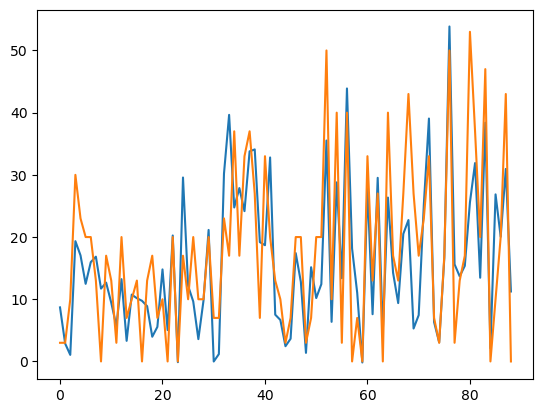

In [100]:
plt.plot(preds_arr[:, 0], label="model")
plt.plot(true_vals_arr[:, 0], label="true")

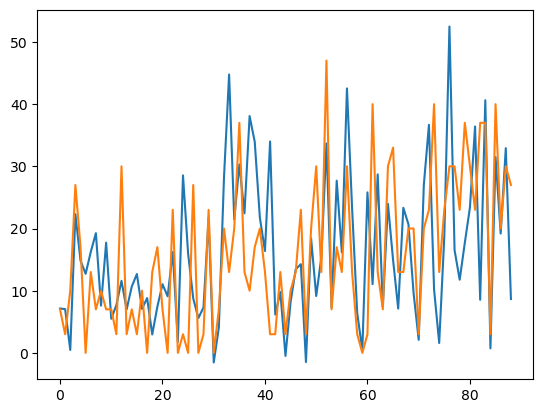

In [103]:
plt.plot(preds_arr[:, 4], label="model")
plt.plot(true_vals_arr[:, 4], label="true")